# **Linking In-context Learning in Transformers to Human Episodic Memory - Demo**

## Environment Setup

In [1]:
import google.colab
# Install TransformerLens
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
# Install PySvelte (used to plot attention patterns)
!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
%pip install git+https://github.com/neelnanda-io/PySvelte.git
%pip install typeguard==2.13.3
%pip install typing-extensions

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-1eekfy9s
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-1eekfy9s
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 5a374ec4b33cec6281b37494175d14f06c75dcfd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import modules & dependencies
import random, gc, os, shutil, math
from functools import partial

import numpy as np
import torch, joblib
import einops
import transformer_lens
from transformer_lens import HookedTransformer, ActivationCache
import transformer_lens.utils as utils
from transformer_lens.head_detector import get_supported_heads, detect_head
from transformer_lens.loading_from_pretrained import get_checkpoint_labels

from matplotlib import pyplot as plt
import plotly.express as px
import pysvelte

In [3]:
torch.set_grad_enabled(False)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Experiment hyperparameters

In [5]:
token_num = 100       # number of tokens in all input prompts
max_lag = 8             # maximum lag for computing average attention scores in either (forward/backward) direction

## Auxiliary functions

In [ ]:
def design_prompt(model):
  '''
  Construct a prompt to probe attention scores/patterns from the model vocabulary (top English words)
  '''
  unembed_bias = model.unembed.b_U
  bias_values, bias_indices = unembed_bias.sort(descending=True)

  i = 0
  word_list = []
  while len(word_list) < token_num:
    s = model.to_string(bias_indices[i])
    i += 1
    if len(s)<2:
      continue
    if s[0] == ' ' and 'a'<=s[1]<='z':  # avoid unwanted tokenization behavior
      word_list.append(s)

  np.random.seed(0)
  rand_seq = np.tile(np.random.permutation(word_list), 2) # include two copies (first study, then recall)
  return rand_seq

In [ ]:
def get_head_CRP(attention_score, max_lag = 8):
  '''
  CRP analysis of attention heads (see Appendix of paper for details)
  '''
  patt_list =[]
  for dest in range(token_num+max_lag,2*token_num-max_lag):
    offset = dest - token_num
    patt_list.append(attention_score[dest][offset-max_lag:offset+max_lag])

  patt_list = np.array(patt_list)
  patt_mean = patt_list.mean(0)
  sem = patt_list.std(0)/np.sqrt(patt_list.shape[0])
  ind = np.arange(-max_lag,max_lag)
  return patt_mean, sem, ind

In [ ]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
  '''
  Visualize the given tensor as a 2D heatmap
  '''
  px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0,
            color_continuous_scale="blues", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def plot_head_detection_scores(scores, zmin=-1, zmax=1,
                                 xaxis="Head", yaxis="Layer", title="Head Matches"):
  '''
  Visualize the head scores as a 2D heatmap
  '''
  imshow(scores, zmin=zmin, zmax=zmax, xaxis=xaxis, yaxis=yaxis, title=title)

In [ ]:
def plot_attn_pattern_from_cache(prompt, cache, layer_i):
  '''
  Visualize the attention pattern of each head in the specified layer
  '''
  attention_pattern = cache["pattern", layer_i, "attn"].squeeze(0)
  attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
  print(f"Layer {layer_i} Attention Heads:")
  return pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)

## Compute attention scores: GPT2-small


In [ ]:
base_model_name = "gpt2-small"
model_name = "gpt2_small"

In [ ]:
# load model
model = HookedTransformer.from_pretrained(base_model_name, device=device)
get_supported_heads()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')


In [ ]:
# construct prompt
rand_seq = design_prompt(model)
assert len(rand_seq) == 2 * token_num
prompt = ''.join(rand_seq)
_, cache = model.run_with_cache(prompt)

In [ ]:
print(prompt)

 so being a which long m from my about d some before make or that out was have other on we like in any over there for right where such would last good were said you all even who both and his if only to an not first no of set their the he has up at will more most as but what do use back just into it p one be had t our time this f under its are also high two new very after with your then made can by get is these people now when they so being a which long m from my about d some before make or that out was have other on we like in any over there for right where such would last good were said you all even who both and his if only to an not first no of set their the he has up at will more most as but what do use back just into it p one be had t our time this f under its are also high two new very after with your then made can by get is these people now when they


In [ ]:
# record induction-head matching scores
head = 'induction_head'
head_scores = detect_head(model, prompt, head, exclude_bos=True,)

In [ ]:
# plot induction-head matching scores (Fig. 2a)
plot_head_detection_scores(head_scores, title=head+" matches", zmin=0)

In [ ]:
# plot attention patterns from each head in layer 5 (Fig. 2b)
plot_attn_pattern_from_cache(prompt, cache, 5)

Layer 5 Attention Heads:
pysvelte components appear to be unbuilt or stale
Running npm install...
Building pysvelte components with webpack...


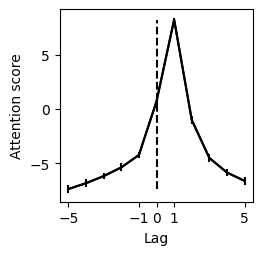

8.212247 -1.0039726


In [ ]:
# plot the average attention scores of L5H1 (Layer 5, Head 1) as a function of relative token position lag
attention_score = cache['blocks.5.attn.hook_attn_scores'][0,1][1:,1:].cpu().numpy()

patt_mean, sem, ind = get_head_CRP(attention_score, max_lag = max_lag)

rg = (-5<=ind) & (ind<=5)
plt.figure(figsize=(2.5,2.5))
plt.plot(ind[rg],patt_mean[rg], color='k')
plt.errorbar(ind[rg],patt_mean[rg], yerr=sem[rg], color='k')
plt.vlines(0, patt_mean[rg].min(), patt_mean[rg].max(), color='k',linestyles='--')
plt.xticks([-5,-1,0,1,5])
plt.xlabel('Lag')
plt.ylabel('Attention score')
plt.show()

print(patt_mean[ind==1][0],patt_mean[ind==2][0])

In [ ]:
n_layers, n_heads = head_scores.shape

# sort head scores and get head labels
sort_ind = np.argsort(head_scores.cpu().numpy(), axis=-1)[:,::-1]
labels = np.array([f'L{i}H{j}' for i in range(n_layers) for j in range(n_heads)]).reshape(n_layers, n_heads)
sorted_head_scores = np.take_along_axis(head_scores.cpu().numpy(), sort_ind, axis=-1)
sorted_labels = np.take_along_axis(labels, sort_ind, axis=-1)

In [ ]:
# compute average attention scores for all heads
_, cache = model.run_with_cache(prompt)
CRP_scores = np.zeros([n_layers,n_heads,max_lag*2])
CRP_scores_sem = np.zeros([n_layers,n_heads,max_lag*2])

for layer in range(n_layers):
  for head in range(n_heads):
    attention_score = cache[f'blocks.{layer}.attn.hook_attn_scores'][0,head][1:,1:].cpu().numpy()
    patt_mean, sem, ind = get_head_CRP(attention_score, max_lag = max_lag)
    CRP_scores[layer, head] = patt_mean
    CRP_scores_sem[layer, head] = sem

    patt_mean, sem, ind = get_head_CRP(attention_score, max_lag=max_lag)

sorted_CRP_scores = np.zeros_like(CRP_scores)
sorted_CRP_scores_sem = np.zeros_like(CRP_scores_sem)
for last_dim in range(CRP_scores.shape[-1]):
  sorted_CRP_scores[...,last_dim] = np.take_along_axis(CRP_scores[...,last_dim], sort_ind, axis=1)
  sorted_CRP_scores_sem[...,last_dim] = np.take_along_axis(CRP_scores_sem[...,last_dim], sort_ind, axis=1)

In [ ]:
# compute copying scores
OV_circuit_all_heads = model.OV
full_OV_circuit_eigenvalues = torch.zeros_like(OV_circuit_all_heads.BA[:,:,:,0]).to(torch.complex128)
for L in range(OV_circuit_all_heads.shape[0]):
  for H in range(OV_circuit_all_heads.shape[1]):
    full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads[L,H] @ model.unembed.W_U
    full_OV_circuit_eigenvalues[L,H]=full_OV_circuit.eigenvalues
full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
sorted_copying_score = np.take_along_axis(utils.to_numpy(full_OV_copying_score), sort_ind, axis=-1)

In [ ]:
# save all scores & labels
result_dict = {
    'head_scores': head_scores,
    'sorted_head_scores': sorted_head_scores,
    'CRP_scores': CRP_scores,
    'sorted_CRP_scores': sorted_CRP_scores,
    'CRP_scores_sem': CRP_scores_sem,
    'sorted_CRP_scores_sem': sorted_CRP_scores_sem,
    'copying_score': utils.to_numpy(full_OV_copying_score),
    'sorted_copying_score': sorted_copying_score,
    'labels': labels,
    'sorted_labels': sorted_labels,
    'sort_ind': sort_ind,
}
joblib.dump(result_dict, './{}/all_scores_{}.pkl'.format(base_model_name, model_name))

['./induction_head_all_scores_gpt2-small.pkl']

In [ ]:
# clear cache
del model
gc.collect()
with torch.no_grad():
  torch.cuda.empty_cache()
huggingface_cache_folder = '../root/.cache/huggingface/hub/models--gpt2'
for filename in os.listdir(huggingface_cache_folder):
  file_path = os.path.join(huggingface_cache_folder, filename)
  try:
      if os.path.isfile(file_path) or os.path.islink(file_path):
          os.unlink(file_path)
      elif os.path.isdir(file_path):
          shutil.rmtree(file_path)
  except Exception as e:
      print('Failed to delete %s. Reason: %s' % (file_path, e))

## Compute attention scores and loss over training: Pythia models


In [ ]:
# construct a common prompt for all Pythia models
model = HookedTransformer.from_pretrained("pythia-1b-deduped", device=device)
rand_seq = design_prompt(model)
prompt = ''.join(rand_seq)
print(prompt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-1b-deduped into HookedTransformer
 but o the first g within so some m r has based very from on re over just t at if set of be he out for most full you we such w d was when an before f do in like s no to is all under p a en there and also which through or even un b with de without up will any both now by per one more c i had using not what where v this after two e pre sub can that while n are non it about as other then have l only but o the first g within so some m r has based very from on re over just t at if set of be he out for most full you we such w d was when an before f do in like s no to is all under p a en there and also which through or even un b with de without up will any both now by per one more c i had using not what where v this after two e pre sub can that while n are non it about as other then have l only


In [ ]:
base_model_name = "pythia-70m-deduped-v0"

In [ ]:
n_cp = len(get_checkpoint_labels(base_model_name)[0])
model_loss = []

for cp in list(range(0, n_cp, 10)) + [n_cp-1]:
  print('Saving checkpoint {}...'.format(cp))
  # load model
  model = HookedTransformer.from_pretrained(base_model_name, device=device, checkpoint_index=cp)
  model_name = '_'.join(base_model_name.split('-')[:2]) + '_cp{}'.format(cp)

  get_supported_heads()

  _, cache = model.run_with_cache(prompt)

  # save loss
  loss = model(prompt, return_type='loss')
  model_loss.append(loss.numpy().item())

  # record head scores
  head = 'induction_head'
  head_scores = detect_head(model, prompt, head, exclude_bos=True,)

  n_layers, n_heads = head_scores.shape

  # sort head scores and get head labels
  sort_ind = np.argsort(head_scores.cpu().numpy(), axis=-1)[:,::-1]
  labels = np.array([f'L{i}H{j}' for i in range(n_layers) for j in range(n_heads)]).reshape(n_layers, n_heads)
  sorted_head_scores = np.take_along_axis(head_scores.cpu().numpy(), sort_ind, axis=-1)
  sorted_labels = np.take_along_axis(labels, sort_ind, axis=-1)

  # compute attention patterns for all heads
  _, cache = model.run_with_cache(prompt)
  CRP_scores = np.zeros([n_layers,n_heads,max_lag*2])
  CRP_scores_sem = np.zeros([n_layers,n_heads,max_lag*2])

  for layer in range(n_layers):
    for head in range(n_heads):
      attention_score = cache[f'blocks.{layer}.attn.hook_attn_scores'][0,head][1:,1:].cpu().numpy()
      patt_mean, sem, ind = get_head_CRP(attention_score, max_lag = max_lag)
      CRP_scores[layer, head] = patt_mean
      CRP_scores_sem[layer, head] = sem

      patt_mean, sem, ind = get_head_CRP(attention_score, max_lag=max_lag)

  sorted_CRP_scores = np.zeros_like(CRP_scores)
  sorted_CRP_scores_sem = np.zeros_like(CRP_scores_sem)
  for last_dim in range(CRP_scores.shape[-1]):
    sorted_CRP_scores[...,last_dim] = np.take_along_axis(CRP_scores[...,last_dim], sort_ind, axis=1)
    sorted_CRP_scores_sem[...,last_dim] = np.take_along_axis(CRP_scores_sem[...,last_dim], sort_ind, axis=1)

  # get copying scores
  OV_circuit_all_heads = model.OV
  full_OV_circuit_eigenvalues = torch.zeros_like(OV_circuit_all_heads.BA[:,:,:,0]).to(torch.complex128)
  for L in range(OV_circuit_all_heads.shape[0]):
    for H in range(OV_circuit_all_heads.shape[1]):
      full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads[L,H] @ model.unembed.W_U
      full_OV_circuit_eigenvalues[L,H]=full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
  sorted_copying_score = np.take_along_axis(utils.to_numpy(full_OV_copying_score), sort_ind, axis=-1)

  # save all scores
  result_dict = {
      'head_scores': head_scores,
      'sorted_head_scores': sorted_head_scores,
      'CRP_scores': CRP_scores,
      'sorted_CRP_scores': sorted_CRP_scores,
      'CRP_scores_sem': CRP_scores_sem,
      'sorted_CRP_scores_sem': sorted_CRP_scores_sem,
      'copying_score': utils.to_numpy(full_OV_copying_score),
      'sorted_copying_score': sorted_copying_score,
      'labels': labels,
      'sorted_labels': sorted_labels,
      'sort_ind': sort_ind,
  }
  joblib.dump(result_dict, './{}/all_scores_{}_cp{}.pkl'.format(base_model_name, model_name, cp))

  print('Saved checkpoint {}.'.format(cp))

  # clear cache
  del model
  gc.collect()
  with torch.no_grad():
    torch.cuda.empty_cache()
  huggingface_cache_folder = '../root/.cache/huggingface/hub/models--EleutherAI--{}'.format(base_model_name)
  for filename in os.listdir(huggingface_cache_folder):
    file_path = os.path.join(huggingface_cache_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

Saving checkpoint 0...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 0.
Saving checkpoint 10...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 10.
Saving checkpoint 20...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 20.
Saving checkpoint 30...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 30.
Saving checkpoint 40...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 40.
Saving checkpoint 50...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 50.
Saving checkpoint 60...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 60.
Saving checkpoint 70...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 70.
Saving checkpoint 80...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 80.
Saving checkpoint 90...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 90.
Saving checkpoint 100...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 100.
Saving checkpoint 110...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 110.
Saving checkpoint 120...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 120.
Saving checkpoint 130...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 130.
Saving checkpoint 140...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 140.
Saving checkpoint 142...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped-v0 into HookedTransformer
Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')
Saved checkpoint 142.


In [ ]:
np.save('./loss_{}.npy'.format(base_model_name), np.array(model_loss))

## Fitting an attention head to human-like asymmetric contiguity bias

In [6]:
max_dist = max_lag                     # magnitude of maximum CRP relative lag computed
beta_gridsize = 1/20                    # size of each grid for grid search of beta
gamma_gridsize = 1/10                 # size of each grid for grid search of gamma
select_range = 5                        # magnitude of maximum CRP relative lag considered for fitting

In [7]:
# load saved attention scores
all_head_scores = joblib.load('./gpt2-small/all_scores_gpt2_small.pkl')

In [8]:
# load pre-computed CRP
crp = np.load('./saved_crps/cmr_crp_avg_20_11.npy')
crp_sem = np.load('./saved_crps/cmr_crp_sem_20_11.npy')
crp_params = np.mgrid[beta_gridsize:1+beta_gridsize:beta_gridsize, 0:1+beta_gridsize:beta_gridsize,
                      0:1+gamma_gridsize:gamma_gridsize]
crp_range = np.arange(-max_dist, max_dist+1)

In [9]:
def load_scores_in_range(all_head_scores, score_key, select_range=5):
  # load scores from the recorded attention heads (e.g., attention scores, sem of attention scores)
  # narrow down to the given range
  attn_scores = all_head_scores[score_key]
  max_lag = attn_scores.shape[-1] // 2
  ind = np.arange(-max_lag, max_lag)
  attn_range = (-select_range <= ind) & (ind <= select_range)
  return attn_scores[:,:,attn_range]

In [10]:
def get_crp(idx_beta_enc, idx_beta_rec, idx_gamma_ft, select_range=5, sem=False):
  # get normalized CRP in the specified range and standard errors if specified
  select_idx = (crp_range >= -select_range) & (crp_range <= select_range)
  d = crp[idx_beta_enc, idx_beta_rec, idx_gamma_ft, select_idx]
  if sem:
    err = crp_sem[idx_beta_enc, idx_beta_rec, idx_gamma_ft, select_idx]
    return d / d.sum(), err / d.sum()
  else:
    return d / d.sum()

def scale_crp_to_attn(cmr_crp, attn_scores):
  # scale CRP to the same range as attn_scores (attention scores)
  # assuming the minimum value of attn_scores is zero
  assert(attn_scores.min() == 0)
  cmr_crp_scaled = cmr_crp - cmr_crp.min()
  scale_factor = attn_scores.max() / cmr_crp_scaled.max()
  cmr_crp_scaled = cmr_crp_scaled * scale_factor
  return cmr_crp_scaled, scale_factor

def get_head_mse(attn_scores, idx_beta_enc, idx_beta_rec, idx_gamma_ft):
  # compute the MSE between an attention score pattern and a CRP from specified CMR params
  # the two patterns are scaled to the same range for fitting
  cmr_crp = get_crp(idx_beta_enc, idx_beta_rec, idx_gamma_ft)
  assert(attn_scores.size == cmr_crp.size)

  attn_scores_scaled = attn_scores - attn_scores.min()
  cmr_crp_scaled, scale_factor = scale_crp_to_attn(cmr_crp, attn_scores_scaled)
  weight = np.ones_like(attn_scores_scaled)
  result = {
    'pattern': cmr_crp,
    'pattern_scaled': cmr_crp_scaled,
    'attn_scaled': attn_scores_scaled,
    'scale_factor': scale_factor,
    'MSE': np.mean((cmr_crp_scaled - attn_scores_scaled) ** 2 * weight / np.var(attn_scores_scaled)),
  }
  return result

In [11]:
def fit_head_cmr(attn_scores):
  # compute the CMR distance between the average attention scores and all CRPs
  param_dim = crp.shape[:-1]
  mse = np.zeros(param_dim)
  patterns = np.zeros(tuple(list(param_dim) + [attn_scores.size]))
  pattern_scaled = np.zeros(tuple(list(param_dim) + [attn_scores.size]))
  attn_scaled = np.zeros(tuple(list(param_dim) + [attn_scores.size]))
  scale_factors = np.zeros(param_dim)
  for i in range(crp.shape[0]):
    for j in range(crp.shape[1]):
      for k in range(crp.shape[2]):
        res = get_head_mse(attn_scores, i, j, k)
        mse[i,j,k], patterns[i,j,k] = res['MSE'], res['pattern']
        pattern_scaled[i,j,k] = res['pattern_scaled']
        attn_scaled[i,j,k] = res['attn_scaled']
        scale_factors[i,j,k] = res['scale_factor']

  # find the best fit
  fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft = np.unravel_index(np.argmin(mse), mse.shape)
  fitted_params = crp_params[:, fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft]
  fitted_scale_factor = scale_factors[fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft]
  head_fit = {
    'MSE': mse[fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft],
    'params': fitted_params,
    'scale_factors': fitted_scale_factor,
    'patterns': patterns[fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft],
    'pattern_scaled': pattern_scaled[fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft],
    'attn_scaled': attn_scaled[fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft],
  }
  return head_fit

def fit(attn_scores):
  # fit all attention heads
  n_layers, n_heads, n_score = attn_scores.shape
  fitted_mse = np.zeros((n_layers, n_heads))
  fitted_params = np.zeros((n_layers, n_heads, len(crp.shape)-1))
  fitted_patterns = np.zeros((n_layers, n_heads, n_score))
  fitted_pattern_scaled = np.zeros((n_layers, n_heads, n_score))
  attn_scaled = np.zeros((n_layers, n_heads, n_score))
  fitted_scale_factors = np.zeros((n_layers, n_heads))

  for l in range(n_layers):
    for h in range(n_heads):
      attn_pattern = attn_scores[l,h]
      head_fit = fit_head_cmr(attn_pattern)
      fitted_mse[l,h] = head_fit['MSE']
      fitted_params[l,h] = head_fit['params']
      fitted_patterns[l,h] = head_fit['patterns']
      fitted_pattern_scaled[l,h] = head_fit['pattern_scaled']
      attn_scaled[l,h] = head_fit['attn_scaled']
      fitted_scale_factors[l,h] = head_fit['scale_factors']

  fit_res = {
    'fitted_MSE': fitted_mse,
    'fitted_params': fitted_params,
    'fitted_patterns': fitted_patterns,
    'fitted_pattern_scaled': fitted_pattern_scaled,
    'attn_scaled': attn_scaled,
    'fitted_scale_factors': fitted_scale_factors,
  }
  return fit_res

In [22]:
def plot_fit(fit_res, attn_scores, attn_scores_sem, labels, n_row=3):
  n_layers, n_heads = fit_res['fitted_MSE'].shape
  for l in range(n_layers):
    # plot the fitted CRP curve over each attention pattern
    plt.figure(figsize=[12,12])
    x = np.arange(-select_range, select_range+1)
    n_col = math.ceil(n_heads/n_row)
    for h in range(n_heads):
      plt.subplot(n_row, n_col, h+1)
      attn_patt = attn_scores[l,h]
      plt.plot(x, attn_patt, marker='o', markersize=1,
               color='k', label='Head')
      plt.errorbar(x, attn_patt, yerr=attn_scores_sem[l,h],
                   color='k', alpha=0.6)
      plt.vlines(0, attn_patt.min(), attn_patt.max(),
                 color='k', linestyles='--')
      ax = plt.gca()
      ax.tick_params(axis='both')
      ax.plot(x, fit_res['fitted_pattern_scaled'][l,h] + attn_patt.min(), marker='x', markersize=1,
               color='r', alpha=0.3, label='CMR fit')
      fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft = fit_res['fitted_params'][l,h]
      plt.title('{}\nCMR distance = {:.2}\n' r'$\beta_{{\rm enc}}={:.2},\beta_{{\rm rec}}={:.2},\gamma_{{\rm FT}}={:.2}$'.format(labels[l,h], fit_res['fitted_MSE'][l,h],
                                                                                                              fitted_beta_enc, fitted_beta_rec, fitted_gamma_ft))
      if h >= n_col * (n_row - 1):
        ax.set_xlabel('Lag')
      if h % n_col == 0:
        ax.set_ylabel('Attention scores')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [13]:
# fit all average attention scores for each head
labels = all_head_scores['sorted_labels']
attn_scores = load_scores_in_range(all_head_scores, 'sorted_CRP_scores', select_range=select_range)
attn_scores_sem = load_scores_in_range(all_head_scores, 'sorted_CRP_scores_sem', select_range=select_range)
fit_res = fit(attn_scores)

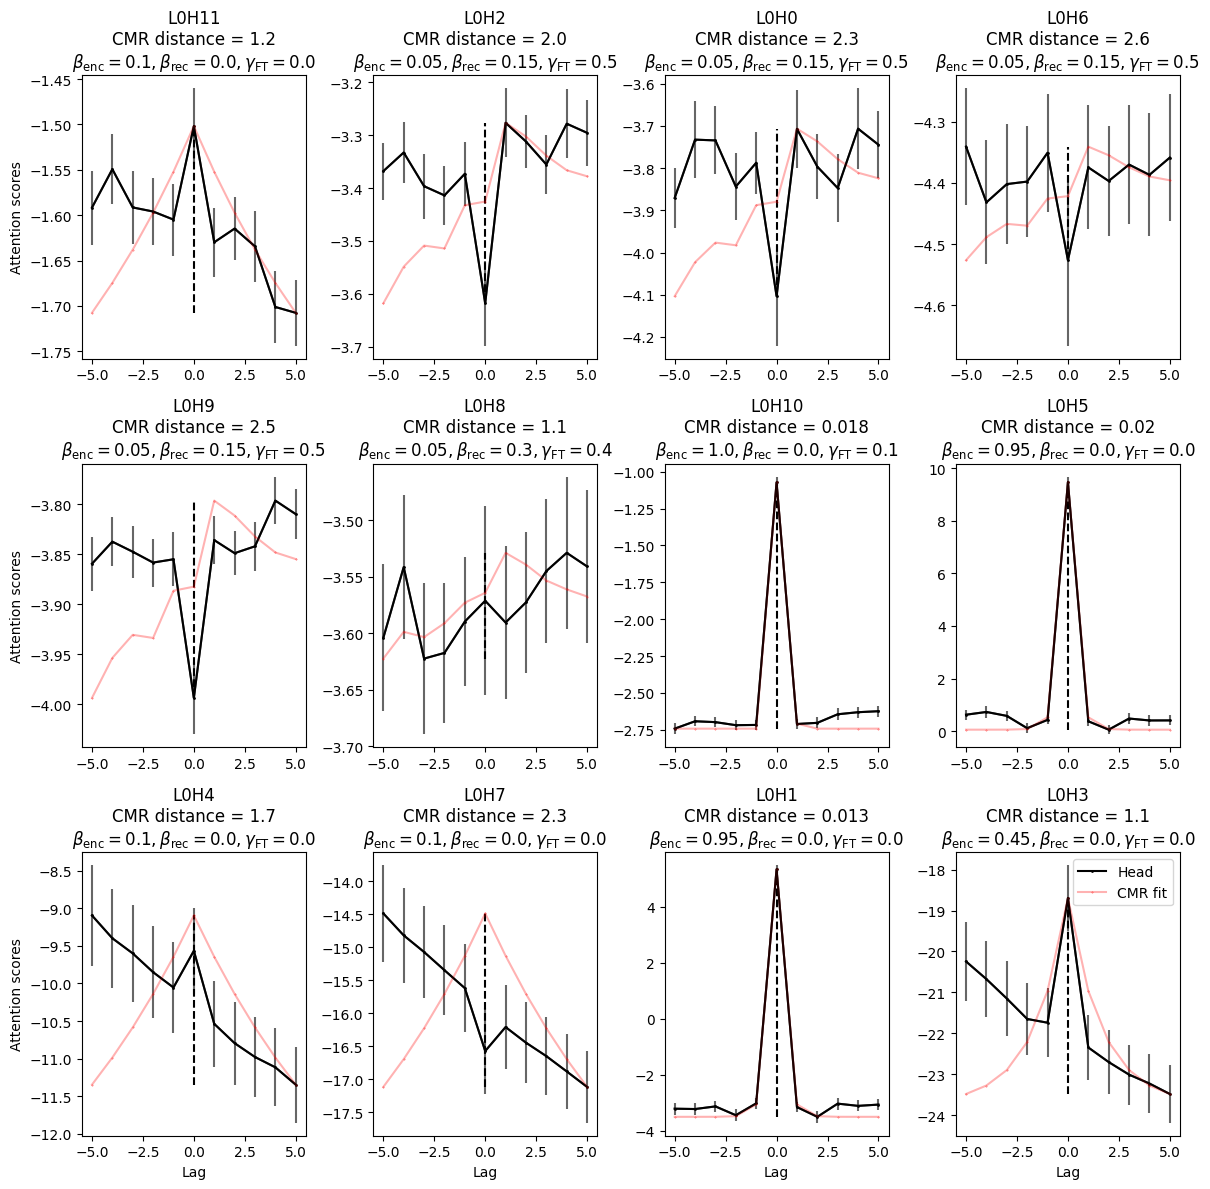

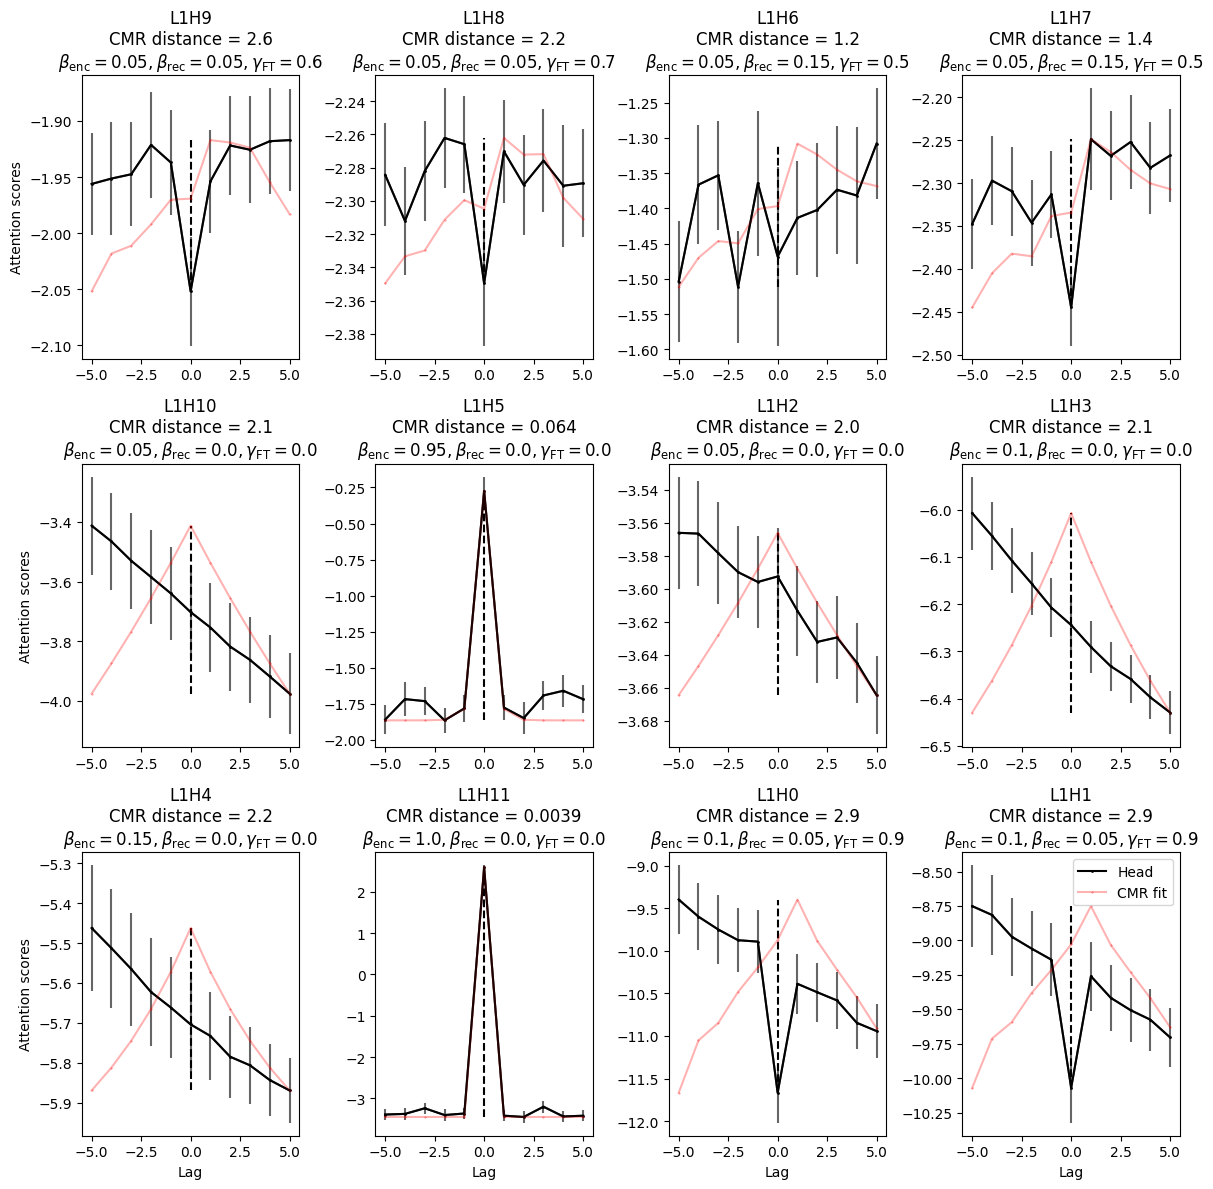

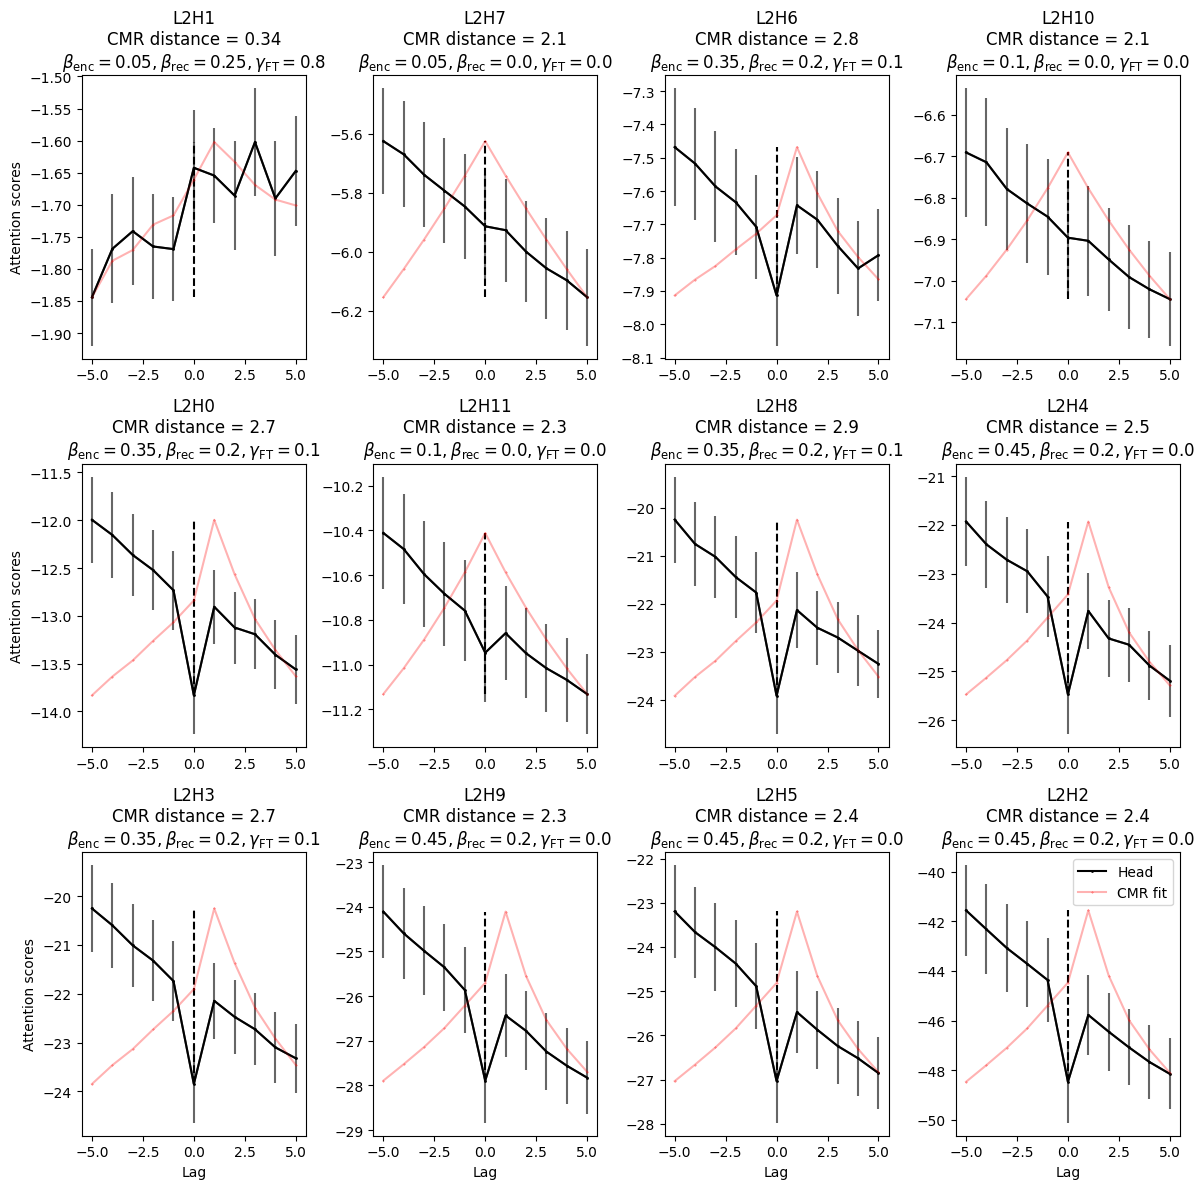

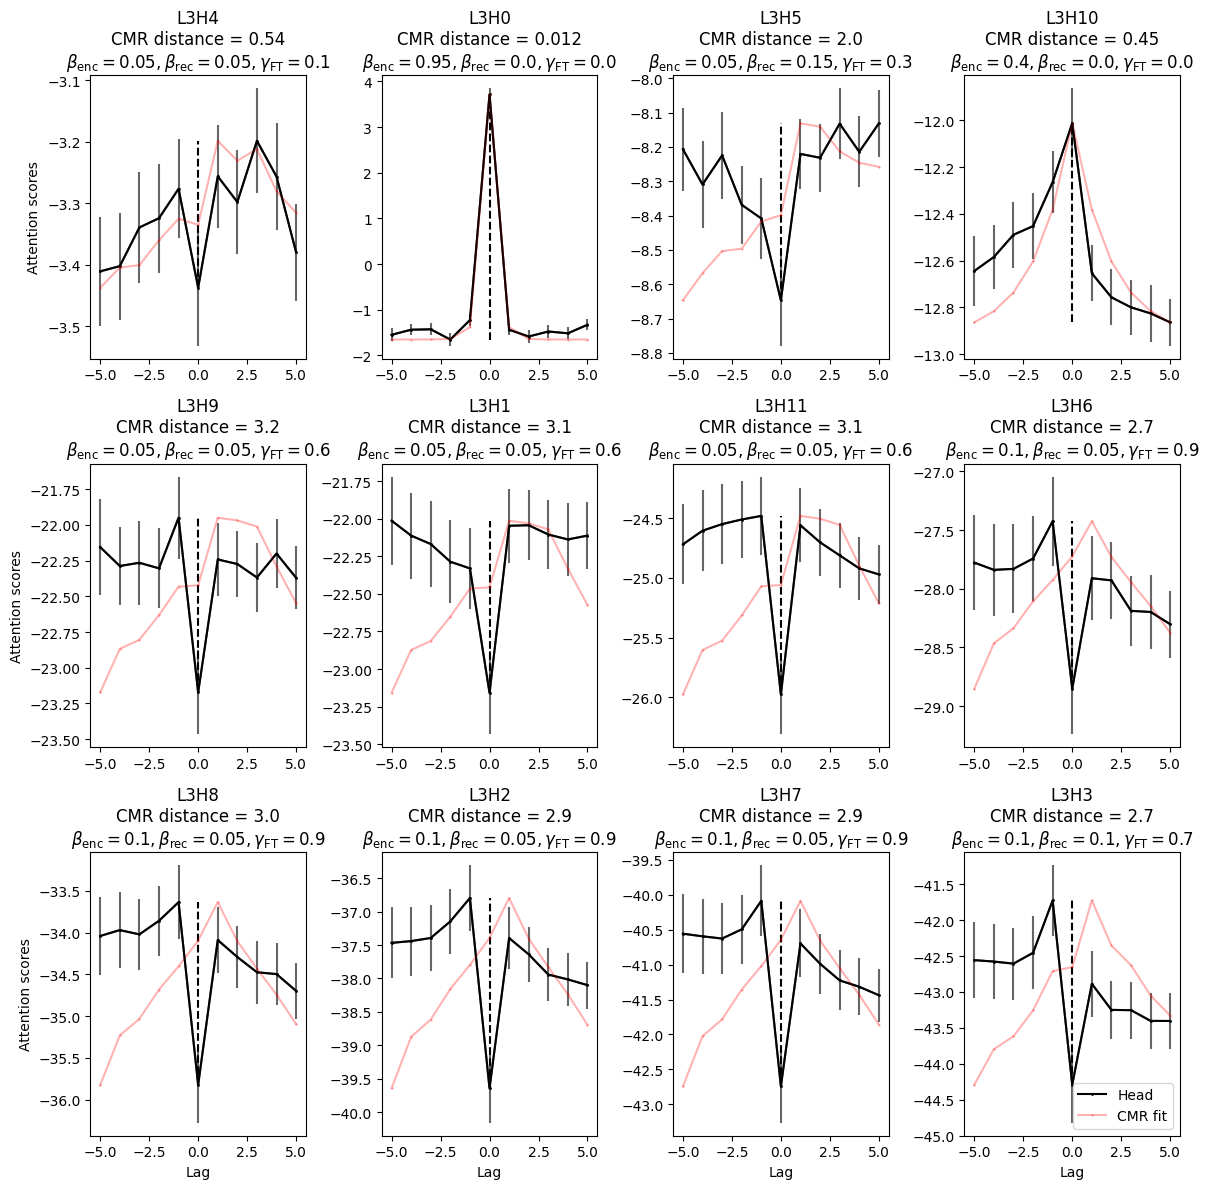

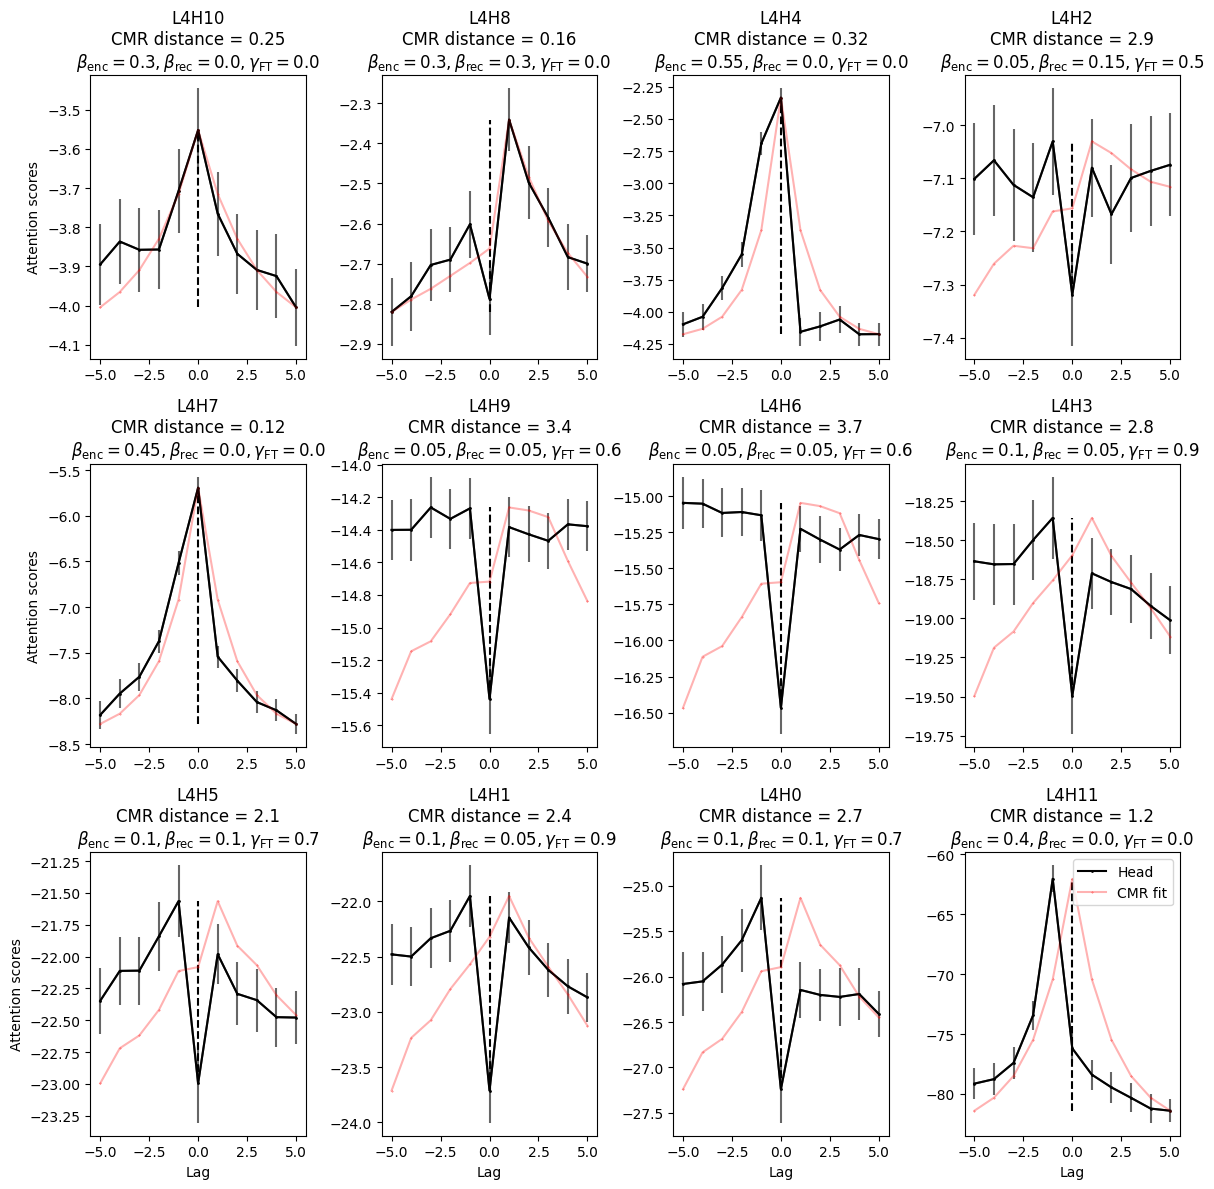

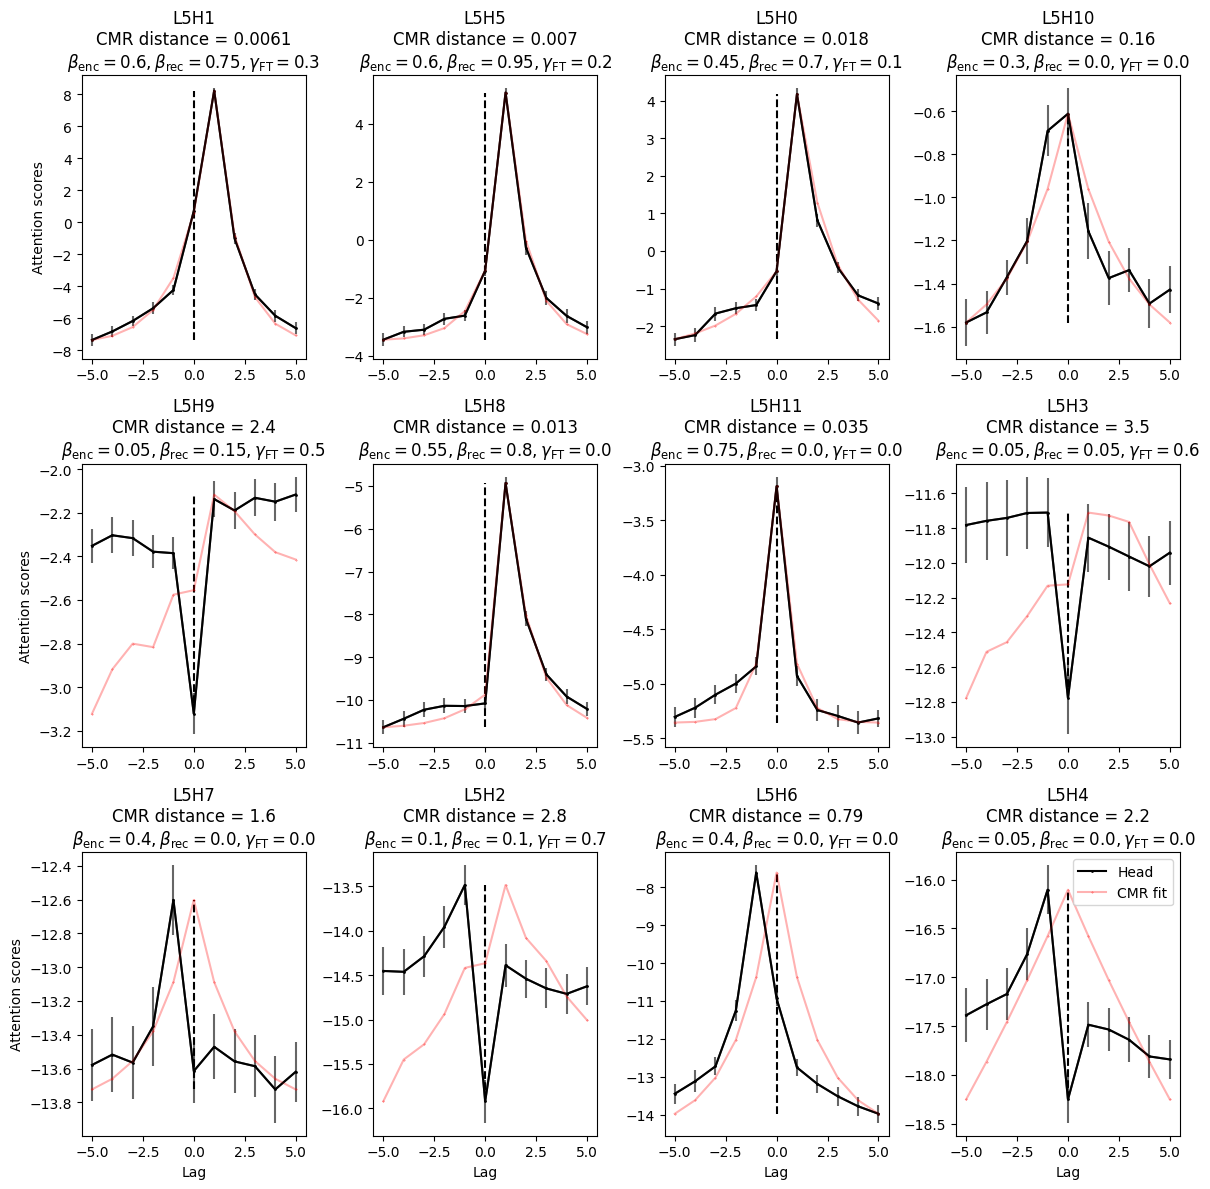

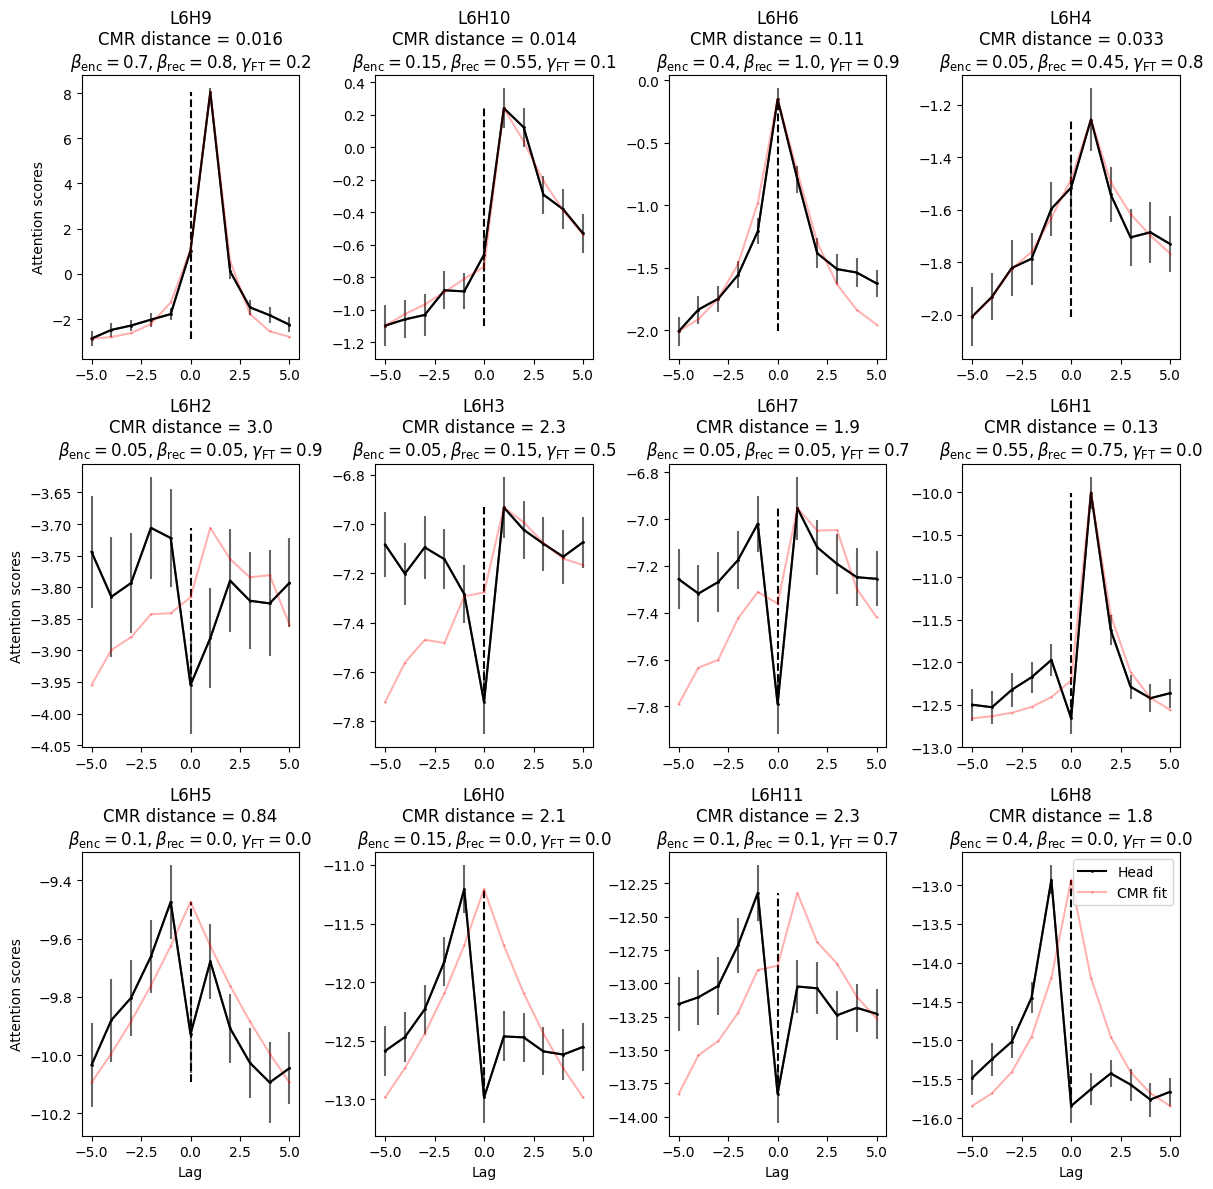

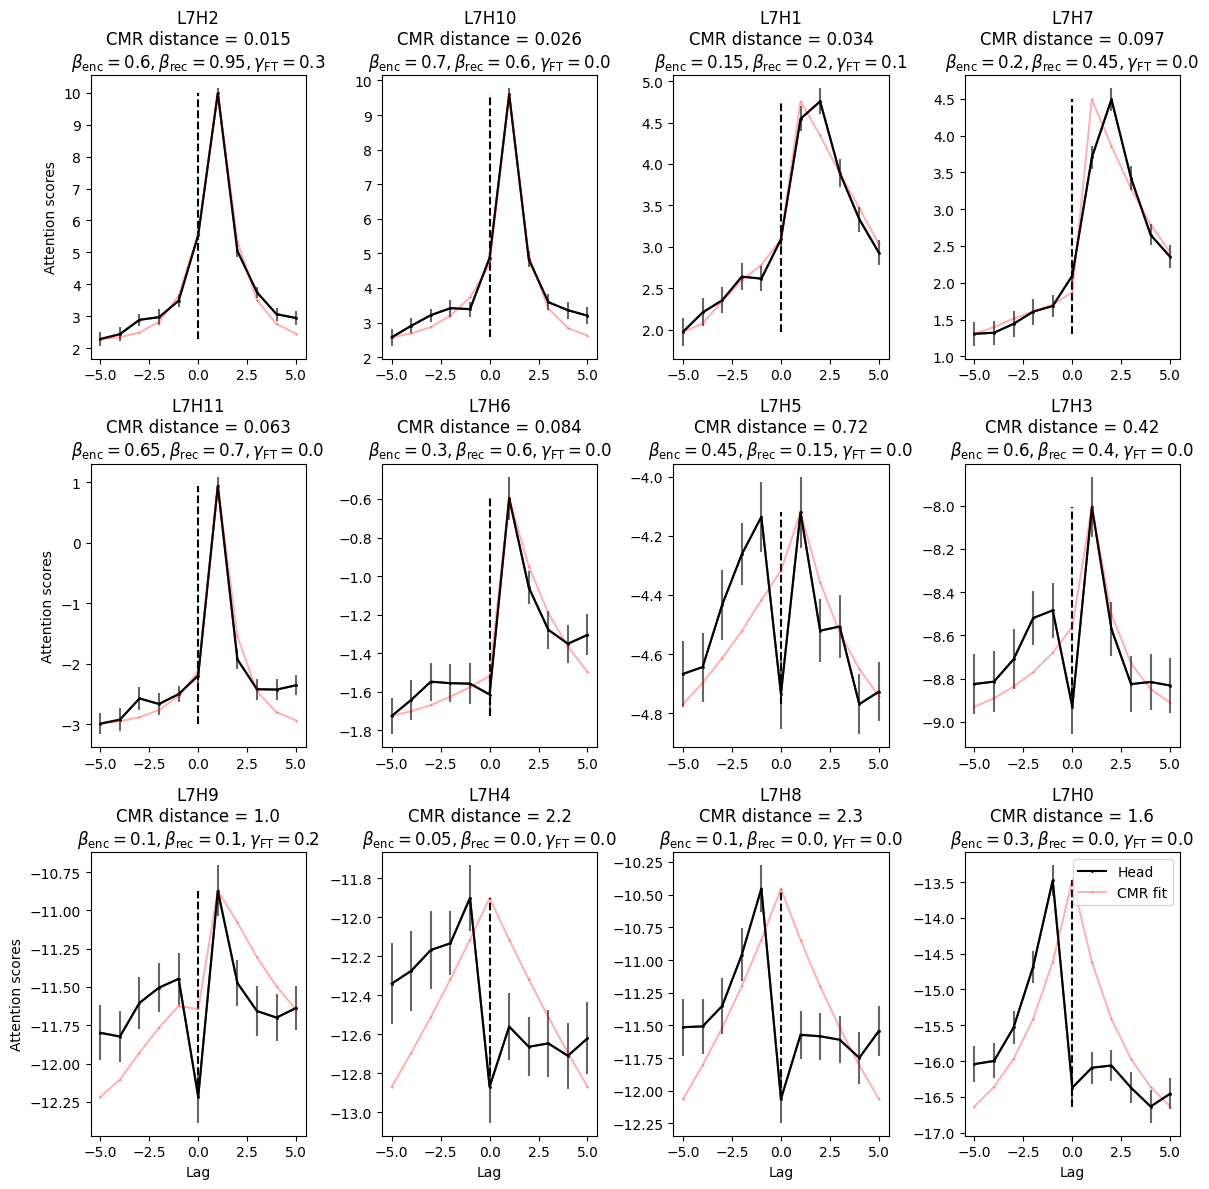

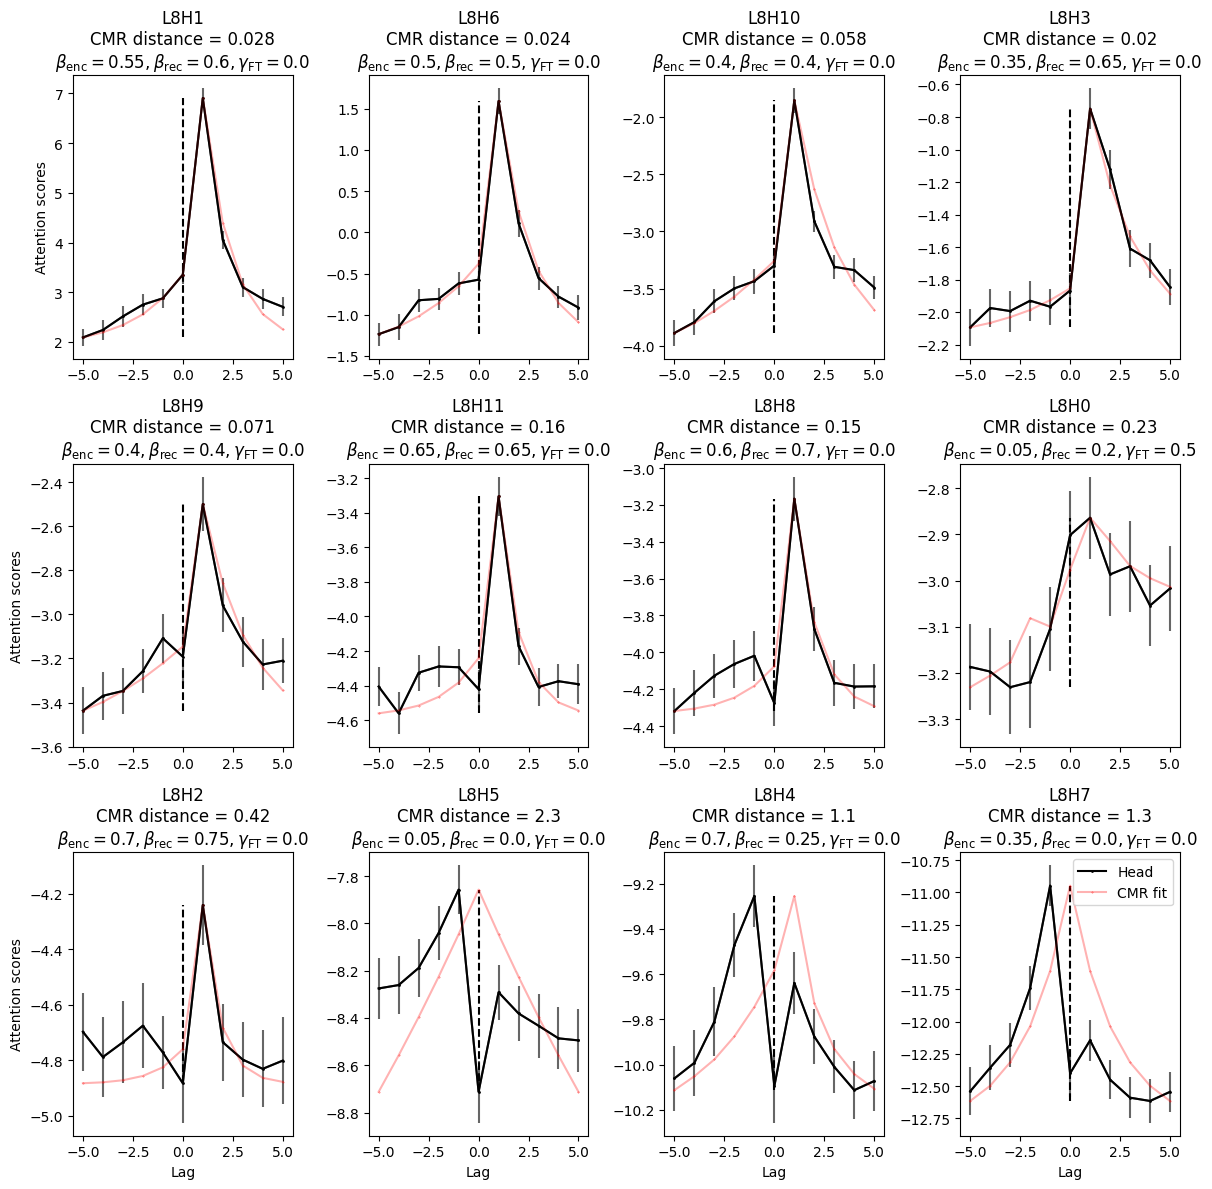

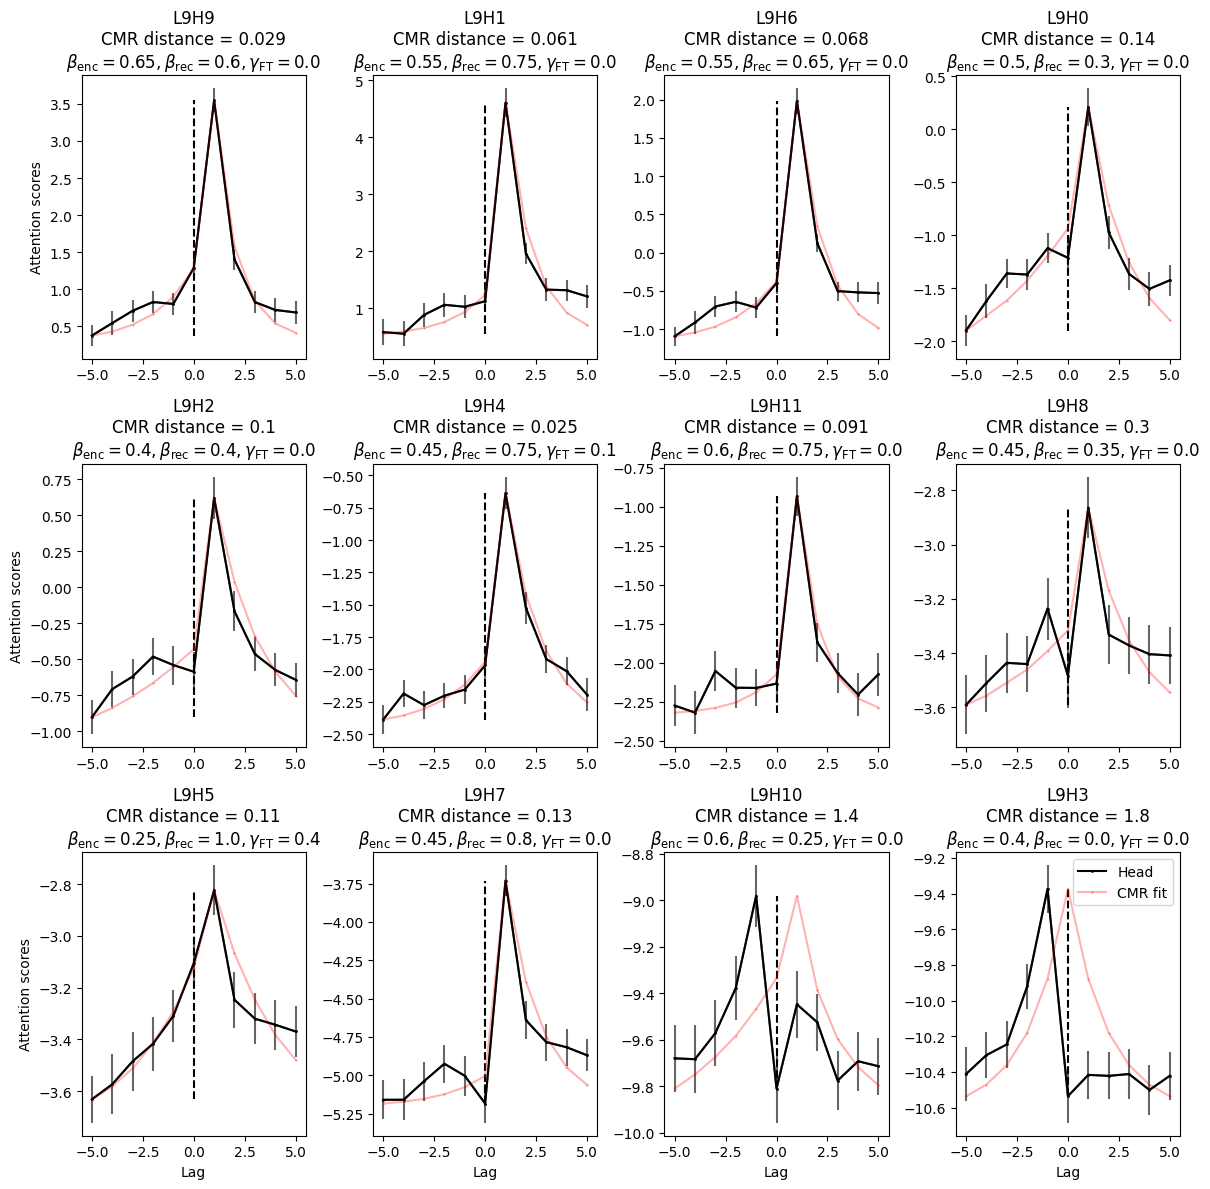

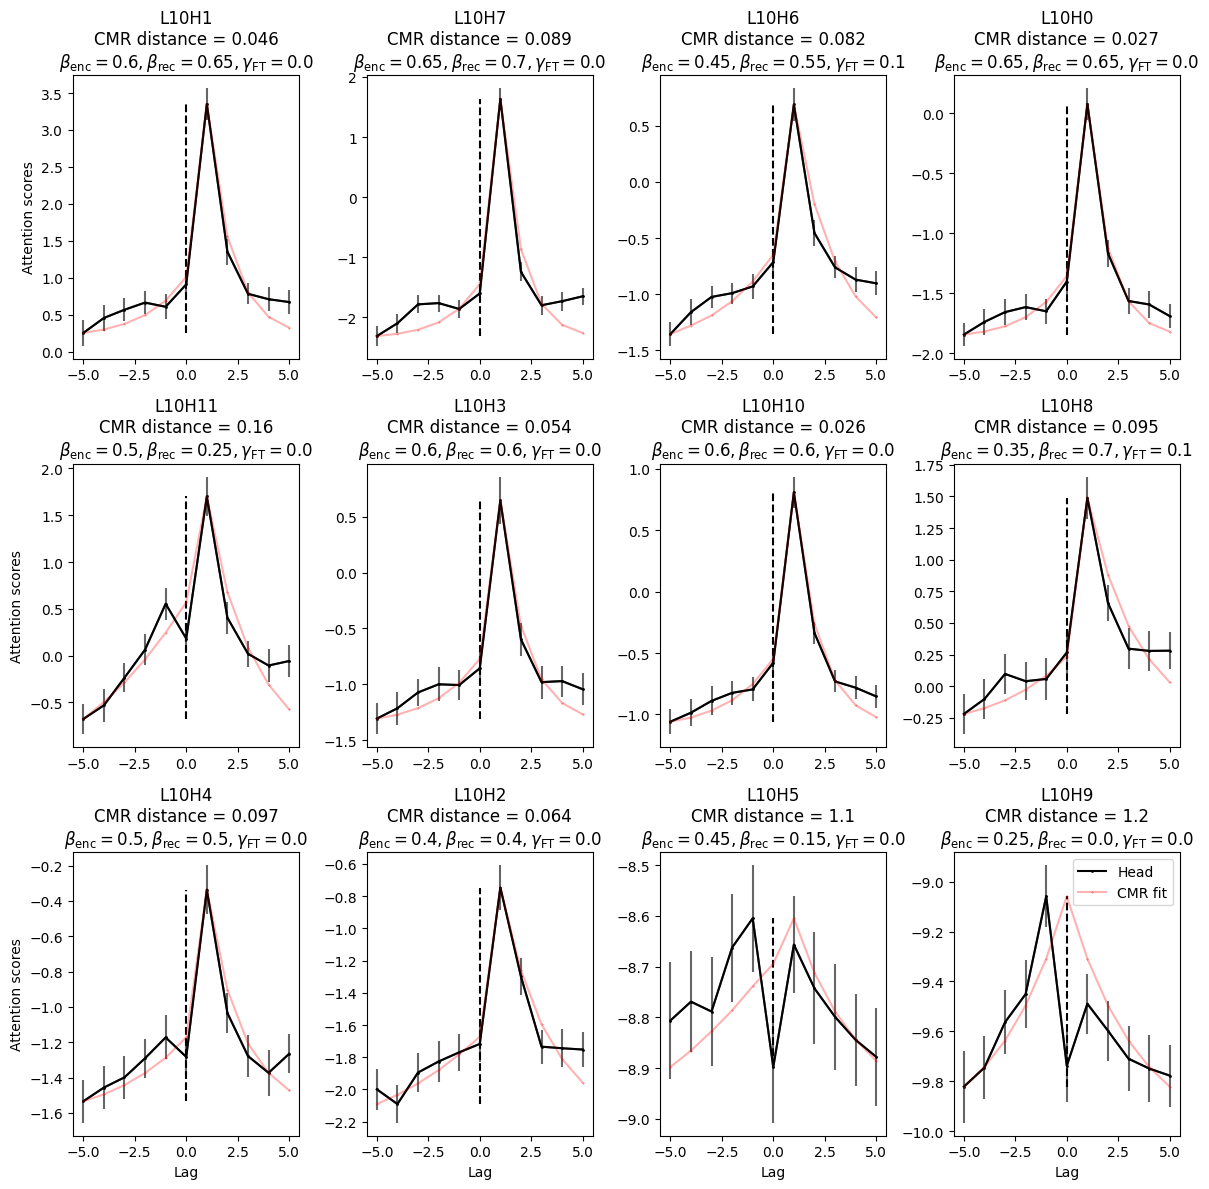

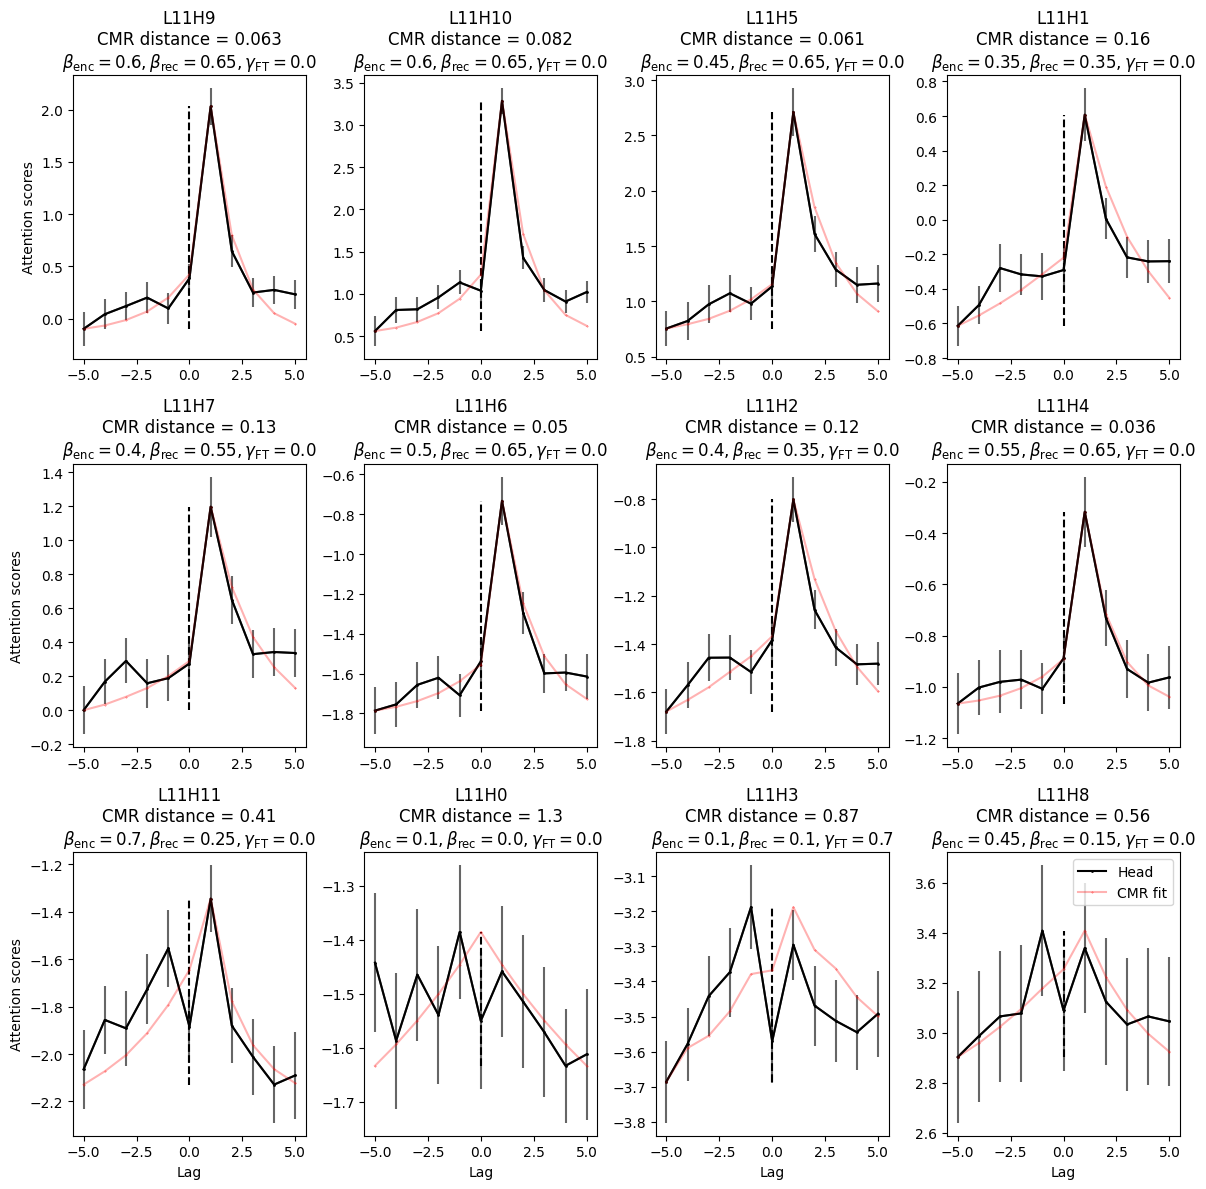

In [23]:
# plot individual head fit
plot_fit(fit_res, attn_scores, attn_scores_sem, labels)